In [1]:
from init import *
from pylab import *
from math import atan2
from scipy.optimize import curve_fit

autotime loaded.
autotime loaded.
black loaded.
black loaded.
time: 1.3 s


<IPython.core.display.Javascript object>

In [2]:
%watermark -n -v -m -iv

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.8.0-36-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

scipy     : 1.5.0
xarray    : 0.15.1
logging   : 0.5.1.2
re        : 2.2.1
geopandas : 0.8.1
h5py      : 2.10.0
pandas    : 1.0.5
sys       : 3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
matplotlib: 3.2.2
numpy     : 1.19.4

time: 179 ms


<IPython.core.display.Javascript object>

In [3]:
def daily_surface_ozone(station):
    filenames = glob.glob("data/surf_ozo/*")
    kwargs = dict(skiprows=range(30))
    data = pd.DataFrame([])
    for filename in filenames:
        name = filename.split("/")[-1]
        df = pd.read_csv(filename, sep="\s+", skiprows=range(28), parse_dates=True)
        df = df[["C32", "TIME.1"]]
        df.columns = ["Date", name]
        df.index = pd.to_datetime(df.Date)
        df[name][abs(df[name]) > 100] = np.nan
        data = pd.concat([data, df], axis=1)
    data = data[["syow", "mcmu", "spol", "neum", "marb", "arht"]]
    return data[station]


def monthly_surface_ozone(station):
    stations = ["arht", "neum", "spol", "syow"]
    oz = pd.DataFrame([])
    for station in stations:
        oz[station] = pd.read_excel("data/surface/%s.xlsx" % station, index_col=0)["O3"]
    return oz[station]

time: 1.6 ms


<IPython.core.display.Javascript object>

In [4]:
class OEE:
    """Estimation of threshold for Ozone Enhancement Episodes [Crisfanelli 2018]"""

    def __init__(self, ozone, freq=1 / 365.25):
        self.oz = ozone
        self.freq = freq

    def get_cutoff(self, plot=True, num_bins=[50, 20], figname=None):
        fil = self.oz.groupby(self.oz.index.dayofyear).transform("mean")
        oz = self.oz.fillna(fil).fillna(method="ffill").fillna(method="bfill")
        self.filled_ozone = oz
        tList = np.arange(len(oz.index))
        yest = self.fitSine(tList, oz.values, self.freq)
        yest = pd.Series(yest, index=oz.index)
        res = oz - yest
        self.sinFit = yest
        self.sinRes = res

        data = res.dropna()

        mean1, sd1, hist_fit1, bin_centres1, hist1 = self.fit_gaussian(
            data, nbins=num_bins[0]
        )

        data1 = data[np.abs(data) >= np.abs(sd1)]

        mean2, sd2, hist_fit2, bin_centres2, hist2 = self.fit_gaussian(
            data1, nbins=num_bins[1]
        )

        pts = self.solve(mean1, mean2, sd1, sd2)
        pt = np.max(pts)

        oee = self.oz[res >= pt]
        noee = self.oz[res < pt]

        if plot:
            fig, axes = plt.subplots(2, 1, figsize=(13, 12))
            ax = axes[0]
            ax.scatter(oee.index, oee, color="r", label="Enhanced Ozone")
            ax.scatter(noee.index, noee, color="k", label="Background Ozone")
            # ax.plot(self.oz, color="k", label="Original Data")
            ax.plot(yest, color="g", label="Sinusoidal Fit")
            ax.plot(res, color="grey", label="Sine Residue", alpha=0.5)
            ax.axhline(0, color="k", ls=":")
            ax.legend(frameon=False)
            ax.set_xlabel("Year")
            ax.set_ylabel("Ozone [ppbv]")

            ax = axes[1]
            ax.scatter(bin_centres1, hist1, label="Test data", color="k")
            ax.plot(bin_centres1, hist_fit1, color="r", lw=4)
            ax.plot(bin_centres2, hist_fit2, color="g", lw=4)
            [ax.axvline(tpt, ls=":", color="k") for tpt in pts]
            ax.set_title("CutOff = %.1f ppbv" % pt, x=0.2, y=0.85)
            ax.set_xlabel("$ \Delta O_3 $ [ppbv]")
            ax.set_ylabel("Count")

            [ax.minorticks_on() for ax in axes]
            plt.subplots_adjust(hspace=0.25)
            if figname:
                plt.savefig(figname, bbox_inches="tight")
            plt.show()
        return pt, oee

    def fit_gaussian(self, data, p0=[1.0, 0.0, 1.0], nbins=50):
        hist, bin_edges = np.histogram(data, density=False, bins=nbins)
        bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
        coeff, _ = curve_fit(self.gaussian_distribution, bin_centres, hist, p0=p0)
        hist_fit = self.gaussian_distribution(bin_centres, *coeff)
        A, mu, sigma = coeff
        return mu, sigma, hist_fit, bin_centres, hist

    @staticmethod
    def fitSine(tList, yList, freq):
        b = matrix(yList).T
        rows = [[sin(freq * 2 * pi * t), cos(freq * 2 * pi * t), 1] for t in tList]
        A = matrix(rows)
        (w, residuals, rank, sing_vals) = lstsq(A, b)
        phi = atan2(w[1, 0], w[0, 0]) * 180 / pi
        amplitude = norm([w[0, 0], w[1, 0]], 2)
        bias = w[2, 0]
        yest = amplitude * sin(tList * freq * 2 * pi + phi * pi / 180.0) + bias
        return yest

    @staticmethod
    def gaussian_distribution(x, *p):
        A, mu, sigma = p
        return A * np.exp(-((x - mu) ** 2) / (2.0 * sigma ** 2))

    @staticmethod
    def solve(m1, m2, std1, std2):
        a = 1 / (2 * std1 ** 2) - 1 / (2 * std2 ** 2)
        b = m2 / (std2 ** 2) - m1 / (std1 ** 2)
        c = m1 ** 2 / (2 * std1 ** 2) - m2 ** 2 / (2 * std2 ** 2) - np.log(std2 / std1)
        return np.roots([a, b, c])

time: 7.47 ms


<IPython.core.display.Javascript object>

In [5]:
tperiod = {
    "spol": "1977-01-01",
    "neum": "1992-07-01",
    "syow": "1999-01-01",
    "arht": "1997-01-01",
    "marb": "2012-01-01",
}

time: 420 µs


<IPython.core.display.Javascript object>

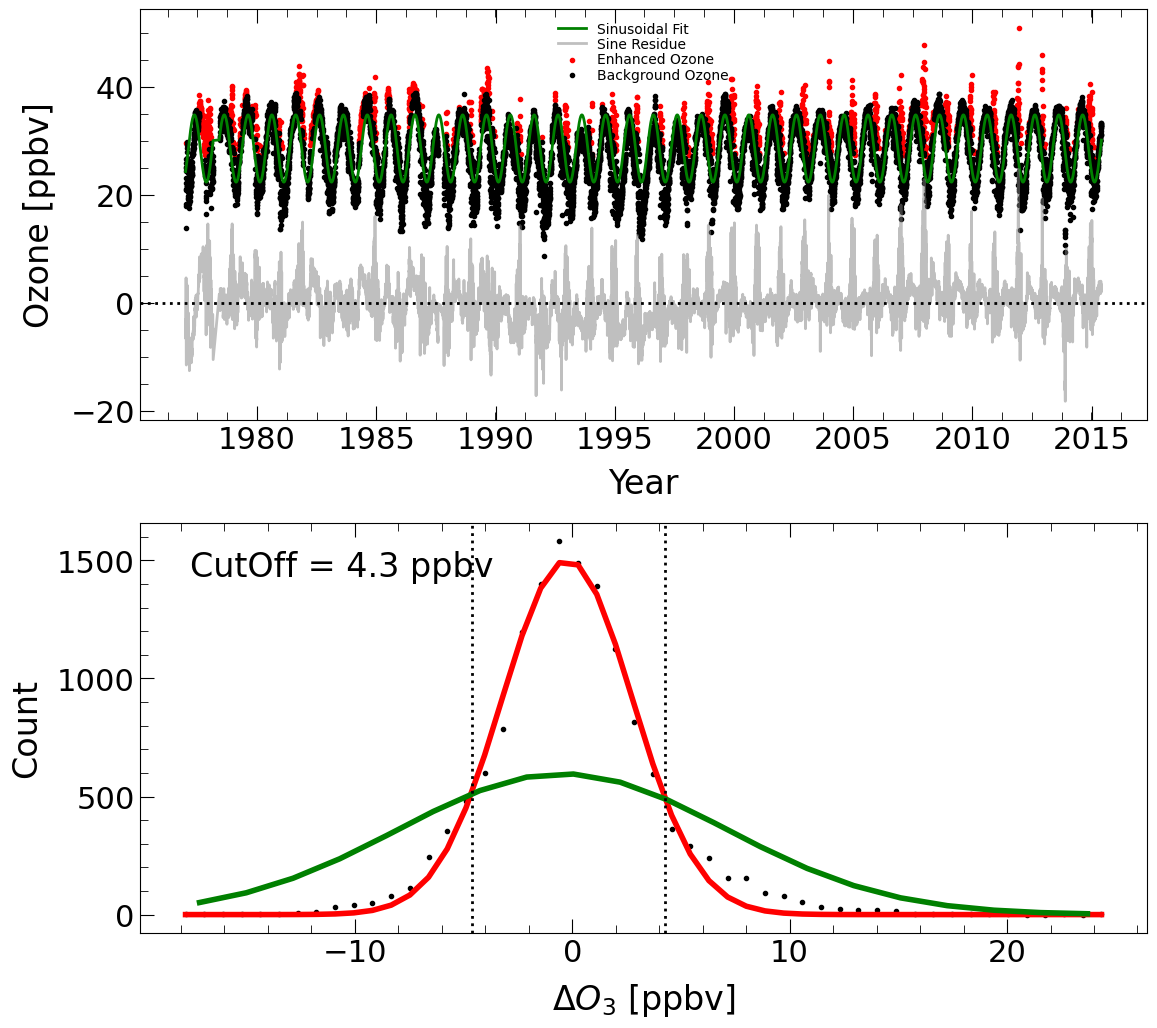

time: 1.94 s


<IPython.core.display.Javascript object>

In [6]:
station = "spol"

doee = pd.DataFrame(index=pd.date_range("1977-01-01", "2020-12-31", freq="D"))
figname = "figs/oee_%s.png" % station
oz = daily_surface_ozone(station)
oz = oz[tperiod[station] : "2015-06-01"]
model = OEE(oz)
co, doee[station] = model.get_cutoff(figname=figname)

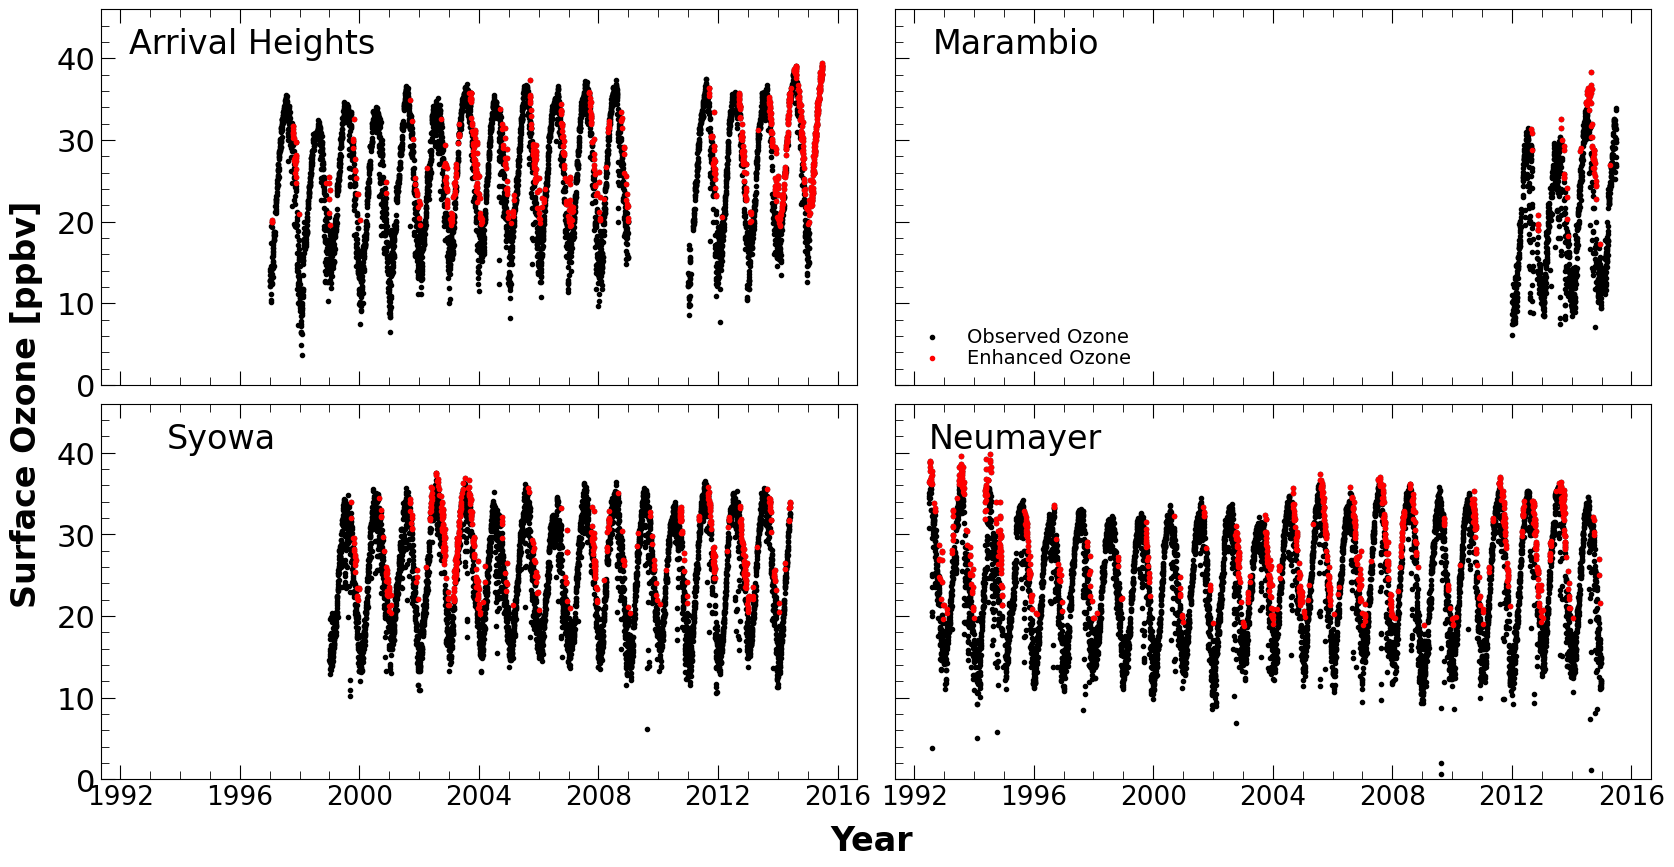

time: 1.93 s


<IPython.core.display.Javascript object>

In [7]:
sname = {
    "arht": "Arrival Heights",
    "syow": "Syowa",
    "neum": "Neumayer",
    "spol": "South Pole",
    "marb": "Marambio",
}

figname = "figs/oee.png"
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()
stations = ["arht", "marb", "syow", "neum"]
for ax, station in zip(axes, stations):
    # print(station)
    oz = daily_surface_ozone(station)
    if station == "syow":
        oz = oz[tperiod[station] : "2014-06-01"]

    else:
        oz = oz[tperiod[station] : "2015-07-01"]

    co, oee = OEE(oz).get_cutoff(plot=False)
    doee[station] = oee
    ax.scatter(oz.index, oz, color="k", label="Observed Ozone")
    ax.scatter(oee.index, oee, color="r", label="Enhanced Ozone")
    ax.tick_params(which="major", axis="x", labelsize=19)
    if station == "arht":
        ax.set_title(sname[station], x=0.2, y=0.86)
    else:
        ax.set_title(sname[station], x=0.16, y=0.86)

axes[1].legend(frameon=False, fontsize=14, loc=3)
axes[-2].set_xlabel("Year", x=1.02, fontweight="bold")
axes[-2].set_ylabel("Surface Ozone [ppbv]", fontweight="bold", y=1)
ax.minorticks_on()
ax.set_ylim([0, 46])
plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.savefig(figname, bbox_inches="tight")
plt.show()

In [8]:
doee.to_excel("./data/oee.xlsx", index_label="Date")

time: 1.07 s


<IPython.core.display.Javascript object>